# MIS 583 Assignment 2: Binary Classification

Before we start, please put your name and ID in following format  
: LASTNAME Firstname, ?000000000   //   e.g.) 李晨愷, M114020035

**Your Answer:**   
Hi I'm 池品叡, B094020030

This assignment aims to work you through the core concepts in implementation a binary classifier. We'll start from implementing a logistic regression from scratch by our own (Part 1) and then implementing it using PyTorch APIs (Part 2).

## Logistic Regression

Logistic regression predicts the probability that an event could occur and typically is used to perform binary classification.

In the first two parts of this assignment, we will cover:
* PyTorch: Tensor operations
* Machine Learning: Data preprocessing, logistic Regression, gradient descent, 

This assignment will walk you through implementing a logistic regression model that classifies whether a person is rich or poor using the UCI adult income dataset in PyTorch.

* In part 1, you will **implement a logistic regression from scratch using PyTorch tensors and tensor operations**. This will help you gain a better understanding of the theoretical concepts discussed in class.
* In part 2, you will **use PyTorch nn.Module to build a logsitic regression** so that you will get familiar with PyTorch APIs.

Note that **You ARE NOT allowed to remove any assertions.**

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.9.5`, `torch==1.8.2` and `torchvision==0.9.2`

In [1]:
!python --version
import torch
import torchvision
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

Python 3.11.6
torch 2.1.0+cu121
torchvision 0.16.0+cpu


## Preparing Data

### Loading Data

We use [adult income](https://www.kaggle.com/wenruliu/adult-income-dataset) dataset from UCI machine learning repository.  

**Abstract**  

Given an individual’s education level, age, gender, occupation, and etc, we want to predict his or her income level.   

**Metadata**  
Number of attributes: 14  
- income: >50K, <=50K
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [2]:
# Download it from cu and upload to colab

# or from the Dropbox
!wget -q -N https://www.dropbox.com/s/1jqeipgof7tukln/assign2_data.zip
!unzip -n assign2_data.zip

'wget' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'unzip' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


There are 4 csv files.


* X_train: training data 
* X_test: training data labels
* Y_train: test data
* Y_test: test data labels.

Each row in X has 106 fields.
Each row Y represents the true label of 0 (poor) and 1 (rich).  

Or you can load train.csv raw data and do your pre-processing.

In [3]:
import numpy as np
import pandas as pd

# Pre-Processed Version
X_train_raw = pd.read_csv('data/X_train.csv')
Y_train_raw = pd.read_csv('data/Y_train.csv')
X_test_raw = pd.read_csv('data/X_test.csv')
Y_test_raw = pd.read_csv('data/Y_test.csv')

X_train_raw.head()

# Or you can do preprocess by yourself
# df = pd.read_csv('data/train.csv')
# ...some preprocessing
# ...remember split into 4 variables with same name by yourself

,age,fnlwgt,sex,capital_gain,capital_loss,hours_per_week,Federal-gov,Local-gov,Never-worked,Private,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,?_native_country
0,39,77516,1,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,1,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,1,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,1,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,0,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


You may already notice that there are two datasets.   One is "training set", and the other is "test set".  
The training set is like **homework of model**. A model uses the training set to learn.  
The testing set is like **quiz of model**. A learned model is tested on the testing set for evaluating how good a model is.



### Pre-Processing Data (3 points)

In a data science process, data cleansing usually cost the most of time.  
Dirty data will cause overfitting or make us ignore those important features. Even if you don't have correct cleansing and format, your model can't run anymore.

In [4]:
import torch
################################################################################
# TODO: Implement Standard Deviation Normalization mentioned in class.         #
# train_data has shape(n_train, feature_dim)                                   #
# test_data has shape(n_test, feature_dim)                                     #
# hint: You should compute mean and std using training data, and apply it to   #
# test.                                                                        #
################################################################################
def compute_mu_std(data):
    '''
    Arguments:
    data -- torch.Tesor, contain data with shape(n, feature_dim)

    Return:
    mu - torch.Tensor, mean value of columns of data with shape(feature_dim)
    sigma - torch.Tensor, std value of columns of data with shape(feature_dim)
    '''
    data_trans = data.transpose(0,1)
    
    mu = data_trans.mean(1)
    sigma = data_trans.std(1)
    
    return mu, sigma

def standard_normalize(data, mu, std):
    '''
    Arguments:
    data -- torch.Tesor, contain data with shape(n, feature_dim)
    mu - torch.Tensor, mean value of columns of data with shape(feature_dim)
    sigma - torch.Tensor, std value of columns of data with shape(feature_dim)

    Return:
    data -- torch.Tensor, normalized data with given mu and sigma
    '''
    idx0 = data.shape[0]
    idx1 = data.shape[1]
    data[:, :] = (data[:, :] - mu[:]) / sigma[:]
    
    return data

# Better not to change code below, except you wanna do your own pre-processing
# pandas > (.values) > numpy > (tensor) > torch.tensor
X_train = torch.tensor(X_train_raw.values, dtype=torch.float)
X_test = torch.tensor(X_test_raw.values, dtype=torch.float)

mu, sigma = compute_mu_std(X_train)

# output the first 5 values of mu and sigma
print('the first 5 means are:', mu[:5])
print('the first 5 sigma are:', sigma[:5])

f_dim = X_train.shape[1]
assert mu.shape == torch.Size([f_dim]), 'Shape of mu is incorrect.'
assert sigma.shape == torch.Size([f_dim]), 'Shape of sigma is incorrect.'

X_train = standard_normalize(X_train, mu, sigma)
X_test = standard_normalize(X_test, mu, sigma)
################################################################################
#                             END OF YOUR CODE                                 #
################################################################################
# make shape(n, 1) > shape(n), like [[1, 2, 3]] > [1, 2, 3]
Y_train = torch.tensor(Y_train_raw.values).squeeze()
Y_test = torch.tensor(Y_test_raw.values).squeeze()

print('Shape of X_train:', X_train.shape) 
print('Shape of X_test:', X_test.shape)  
print('Shape of y_train:', Y_train.shape)
print('Shape of y_test:', Y_test.shape)


assert X_train.dim() == 2
assert Y_train.dim() == 1
# IF you are writting YOUR pre-processing, the tensors may have different shape.
assert X_train.shape == (32561, 106)
assert X_test.shape == (16281, 106)

the first 5 means are: tensor([3.8582e+01, 1.8978e+05, 6.6921e-01, 1.0776e+03, 8.7304e+01])
the first 5 sigma are: tensor([1.3640e+01, 1.0555e+05, 4.7051e-01, 7.3853e+03, 4.0296e+02])
Shape of X_train: torch.Size([32561, 106])
Shape of X_test: torch.Size([16281, 106])
Shape of y_train: torch.Size([32561])
Shape of y_test: torch.Size([16281])


Because the data used to train a deep model may be large, you could not load the model and the whole dataset into memory (GPU or RAM) at the same time.  
So, we split the data into mini-batches.

In [5]:
def make_batch(data, batch_size=128, drop_last=True):
    '''
    Split dataset into batches. 將資料分割為 size=128 的 Batches, 多餘的資料會被丟棄

    Arguments:
    data -- torch.Tensor, data with shape(n, ...)
    batch_size -- int, how many data in your batch
    drop_last -- boolean, drop last datas if your remaining data is < batch_size

    Return:
    out -- torch.Tensor(dtype=torch.float) with shape(n_batch, batch_size, ...)
    '''
    if drop_last:
        n = data.shape[0] // batch_size
    else:
        n = ((data.shape[0] - 1) // batch_size) + 1
    out = np.empty(torch.Size((n, batch_size)) + data.shape[1:], dtype=np.float32)
    print(out.shape)
    for b in range(len(out)):
        out[b] = data[b * batch_size:(b + 1) * batch_size]
    return torch.tensor(out)

X_train_batch = make_batch(X_train)
Y_train_batch = make_batch(Y_train)
X_test_batch = make_batch(X_test)
Y_test_batch = make_batch(Y_test)

(254, 128, 106)
(254, 128)
(127, 128, 106)
(127, 128)


We have prepared the data.  
Let's develop a logistic regression model.

# Part 1: Implement Logistic Regression from Scratch

## Utility function

### Activation Function (3 points)

Logistic Regression uses a logistic function (or called a sigmoid function) to turn a real value into a probability (a value between zero and one). Below depicts the sigmoid function.

**Slide: ch02 p67**

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/640px-Logistic-curve.svg.png)

*Source: wikipedia*

In [6]:
def sigmoid(z): 
    '''
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or torch.Tensor of any size.

    Return:
    s -- torch.Tensor, sigmoid(z)
    '''
    if not isinstance(z, torch.Tensor):
        z = torch.tensor(z, dtype=torch.float)
    ############################################################################
    # TODO: Implement sigmoid (or called logistic) function                    #
    # Slide: ch02 p67                                                          #
    ############################################################################
    # use torch.sigmoid() can do this directly
    # out = z.sigmoid()
    # do not use math library to modify Tensors ><
    out = 1 / (1 + torch.exp(-z))
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    # prevent out is Inf or -Inf
    out = torch.clamp(out, 1e-4, 1-1e-4)
    return out

s_t1 = sigmoid(0)
s_t2 = sigmoid(2)
s_t3 = sigmoid(-1)
print('sigmoid(0)  =', s_t1)
print('sigmoid(2)  =', s_t2)
print('sigmoid(-1) =', s_t3)
msg = 'Your sigmoid: {} isn\'t correct'
assert (s_t1 - 0.5) < 0.001, msg.format(sigmoid(0))
assert (s_t2 - 0.8808) < 0.001, msg.format(sigmoid(2))
assert (s_t3 - 0.2689) < 0.001, msg.format(sigmoid(-1))

sigmoid(0)  = tensor(0.5000)
sigmoid(2)  = tensor(0.8808)
sigmoid(-1) = tensor(0.2689)


### Loss Function (3 points)

Many machine learning applications use the cross-entropy loss as described in class. This loss can be directly derived from information theoretic considerations, which measures the differences between two probability distributions.
In this assignment, we will use the binary cross entropy loss for binary classification.
**Slide: ch02 p74**

In [7]:
import math
def binary_cross_entropy(y_true, y_pred):
    '''
    Compute the binary cross entropy of inputs.

    Arguments:
    y_true -- torch.Tensor, True data with shape(n_size).
    y_pred -- torch.Tensor, Predicted data with shape(n_size)

    Return:
    s -- torch.Tensor, binary_cross_entropy(z)
    '''
    ############################################################################
    # TODO: Implement binary cross entropy                                     #
    # Slide: ch02 p74                                                        #
    ############################################################################
    loss = -torch.mean( (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)))
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return loss

b_t1 = binary_cross_entropy(torch.tensor([1]), torch.tensor([0.5]))
b_t2 = binary_cross_entropy(torch.tensor([1]), torch.tensor([0.8]))
b_t3 = binary_cross_entropy(torch.tensor([1]), torch.tensor([0.9]))
print('bce(1, 0.5)', b_t1)
print('bce(1, 0.8)', b_t2)
print('bce(1, 0.9)', b_t3)
msg = 'Your bce: {} isn\'t correct'
assert (b_t1 - 0.6931) < 0.001, msg.format(b_t1)
assert (b_t2 - 0.2231) < 0.001, msg.format(b_t1)
assert (b_t3 - 0.1054) < 0.001, msg.format(b_t1)

bce(1, 0.5) tensor(0.6931)
bce(1, 0.8) tensor(0.2231)
bce(1, 0.9) tensor(0.1054)


## Logistic Regression Model (4 points)

Let's implement the training algorithm!  

**Slide: ch02 p106 Training algorithm with mini-batch SGD**
 
```python
num_epochs = ... # specify the number of epochs to train initialize parameters w, b
for epoch in range(num_epochs):
    shuffle training data
    for each batch:
        forward propagation to get the predictions/outputs 
        compute loss
        backward propagation to get the gradients
        update parameters using their gradients
```

You should fill out each methods (init, forward, backward, optimizer...)  
Inputs, outputs, format and description is written in docstring `'''doc string there'''`  
**You are NOT allowed to remove any assertion.**

In [8]:
class LogisticRegression:
    def __init__(self, lr, feature_dim):
        '''
        Initialize the learning rate
        Initialize the weights and bias to zeros with correct shapes.
        Note that w and b should be torch.tensor(...)
        The shape of w should be (feature_dim)
        The shape of b should be (1)

        Arguments:
        lr -- float, learning rate (0 < lr <= 1) to control the step of updates.
        feature_dim -- int, the number of features.
        '''
        ########################################################################
        #                           Your code there                            #
        ########################################################################
        self.w = torch.ones(feature_dim, dtype=torch.float32)
        self.b = torch.ones(1, dtype=torch.float32)
        self.lr = lr
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        assert self.w.shape == torch.Size([feature_dim]), 'shape of w is incorrect'
        assert self.b.dtype == torch.float, 'dtype of b should be float'

        # initialize dw, db to zeros
        self.grads = {'dw': torch.zeros(feature_dim, dtype=torch.float), 
                      'db': torch.tensor(0, dtype=torch.float)}

    def forward(self, x):
        '''
        Compute the predicted probability using the w and b for an given input x.
        Store the prediction in self.out, which will be needed in backward pass.

        Arguments: 
        x -- torch.Tensor, input data with shape(n, feature_dim).

        Return:
        out -- sigmoid(x * w + b)
        '''
        ########################################################################
        #                           Your code there                            #
        ########################################################################
        # out should have shape (n, )
        # call sigmoid function turn output into the interval between (0, 1)
        out = sigmoid(torch.matmul(x, self.w) + self.b)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        self.out = out
        assert (out > 0).all() and (out < 1).all(), 'Output should > 0 and < 1'
        assert out.shape == torch.Size([x.shape[0]]), 'Shape of output is incorrect.'
        return self.out
    
    def backward(self, x, y_true):
        '''
        After the forward pass, calculate gradients of w and b (dw and db).
        Store dw and db in self.grads.
        Ref: Slide ch02 102

        Arguments:
        x -- torch.Tensor, input data with shape(n,).
        y_true -- torch.Tensor, true data with shape(n,).
        '''
        y_pred = self.out
        ########################################################################
        #                           Your code there                            #
        # Slide: ch02 p102 Gradient descent implementation                      #
        ########################################################################
        x_trans = torch.transpose(x, 0, 1) # Transpose x tensor first
        N = x.shape[0] # row size
        dw = torch.div(torch.matmul(x_trans, y_pred-y_true), N) # Find gradients of 'w'
        b_sum = torch.sum(y_pred - y_true) # Sum up all distance
        db = torch.div(b_sum, N) # Find gradients of 'b'
        db = torch.tensor([db], dtype=torch.float32)
        ########################################################################
        #                           End of your code                           #
        ########################################################################

        assert dw.shape == self.w.shape, 'Shape of dw is incorrect.'
        assert db.shape == self.b.shape, 'Shape of db is incorrect.'

        self.grads = {'dw': dw, 'db': db}

    def optimize(self):
        '''
        Implement the mini-batch SGD algorithm.
        Use gradients and lr to update the weights and bias.
        '''
        ########################################################################
        #                           Your code there                            #
        ########################################################################
        self.w = self.w - self.lr * self.grads['dw']
        self.b = self.b - self.lr * self.grads['db']
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def predict(self, x):
        '''
        Compute the probability prediction of you model and threshold the 
        probability output at 0.5 to obtain the label.
        hint: you should re-use forward method

        Arguments:
        x -- torch.Tensor, input data with shape(n, feature_dim).

        Return:
        out -- sigmoid(x * w + b) > 0.5 with shape(n,)
        '''
        ########################################################################
        #                           Your code there                            #
        ########################################################################
        out = self.forward(x)
        threshold = .5
        out = (out > threshold)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        assert out.shape == torch.Size([x.shape[0]]), 'Shape of output is incorrect'
        return out

In [9]:
################################################################################
#                             Hyperparameters                                 #
# You can modify these hyperparameters to see how they affect the accuracy    #
################################################################################
lr = 5e-3
max_epochs = 200
log_interval = 5

model = LogisticRegression(lr=lr, feature_dim=X_train.shape[1])

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

### Putting everything together (3 points)

In [10]:
from sklearn.metrics import accuracy_score

for epoch in range(1, max_epochs + 1):
    idxs = torch.randperm(X_train_batch.shape[0]) # make rand idx
    data_loader = ((X_train_batch[i], Y_train_batch[i]) for i in idxs)

    loss_list = [] # save train_loss
    for i, (x, y) in enumerate(data_loader):
        ########################################################################
        # TODO: Combine all the functions together                             #
        ########################################################################
        # hints:
        # 1. get output from forward method, call forward()
        # 2. calculate loss using binary_cross_entropy()
        # 3. using backward method to calculate dw, db, call backward()
        # 4. apply SGD optimize to update model's weights, call optimize()
        output = model.forward(x)
        loss = binary_cross_entropy(y, output)
        model.backward(x, y)
        model.optimize()
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        loss_list.append(loss)

    train_loss_list.append(sum(loss_list) / len(loss_list))
    train_acc_list.append(accuracy_score(Y_train, model.predict(X_train.float())))
    test_loss_list.append(binary_cross_entropy(Y_test, model.forward(X_test.float())))
    test_acc_list.append(accuracy_score(Y_test, model.predict(X_test.float())))
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train loss:', train_loss_list[-1], 'acc:', train_acc_list[-1])
        print('Test loss: ', test_loss_list[-1], 'acc:', test_acc_list[-1])

==================== Epoch 5 ====================
Train loss: tensor(0.9354) acc: 0.7263904671232456
Test loss:  tensor(0.8824) acc: 0.7234813586389043
==================== Epoch 10 ====================
Train loss: tensor(0.5795) acc: 0.7963514634071435
Test loss:  tensor(0.5626) acc: 0.7959584792088938
==================== Epoch 15 ====================
Train loss: tensor(0.4514) acc: 0.8265409539019072
Test loss:  tensor(0.4468) acc: 0.8264848596523555
==================== Epoch 20 ====================
Train loss: tensor(0.4021) acc: 0.8380270876201591
Test loss:  tensor(0.4003) acc: 0.8379706406240403
==================== Epoch 25 ====================
Train loss: tensor(0.3725) acc: 0.8435858849543932
Test loss:  tensor(0.3727) acc: 0.8431914501566243
==================== Epoch 30 ====================
Train loss: tensor(0.3526) acc: 0.8470870059273364
Test loss:  tensor(0.3539) acc: 0.8455868804127511
==================== Epoch 35 ====================
Train loss: tensor(0.3406) acc: 

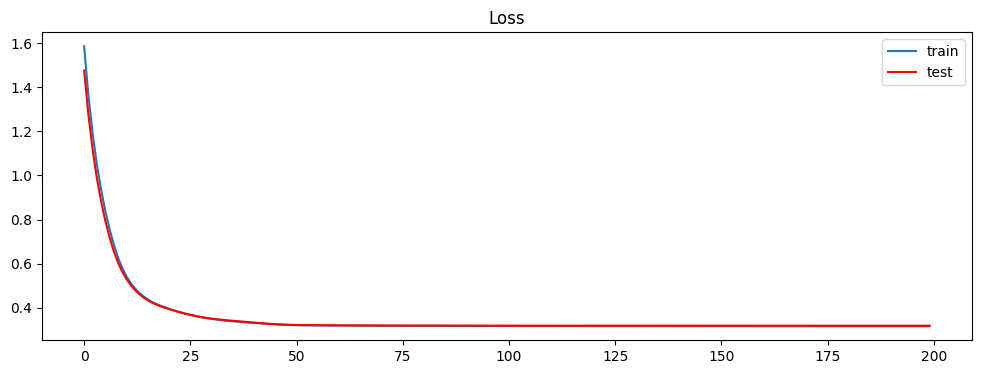

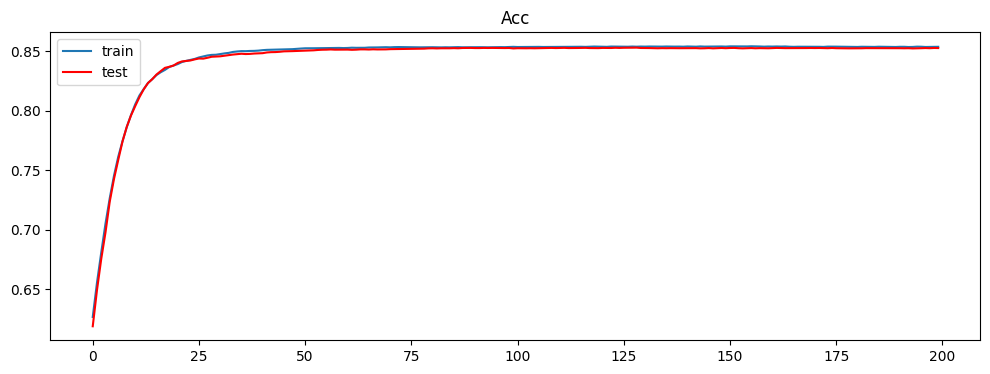

In [11]:
# plot loss and acc
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list, c='r')
plt.legend(['train', 'test'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.legend(['train', 'test'])
plt.title('Acc')
plt.show()

Congratulations! You've made it.

# Implement Logsitic Regression Using PyTorch nn.Module APIs

Now, let's learn to use PyTorch APIs with a few lines to implement a logistic regression model.

In [12]:
import torch
from torch import nn
import torch.nn.functional as F

Let's start with the PyTorch Dataset.  
You may notice that there are the dataset and the data_loader classes.
The Dataset handles the whole dataset.
The Dataloader provides batching, shuffling and many more utility functions about Dataset.  
We will dicuss more about it later.

Use `TensorDataset` and `DataLoader` from `torch.utils.data`.

In [13]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, Y_train.unsqueeze(dim=1).float())
test_dataset = TensorDataset(X_test, Y_test.unsqueeze(dim=1).float())
train_data = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=128, shuffle=False)

PyTorch provides very convenient ways to construct a model. 
1. All models should inherit `nn.Module`.  
2. In `__init__` method, remember to call `super().__init__()` and define the network layers.  
3. In `forward()` method, use the defined layers to build a network model.

PyTorch will use [autograd mechanic](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) to generate `backward()` and get gradients **automatically**. So, we don't need to worry about the gradient computation.

### Define a logistic regression using nn.Module (3 points)

In [14]:
class TorchLogisticRegression(nn.Module):
    def __init__(self, feature_dim):
        '''
        Initiate weights and bias of our model.

        Arguments:
        feature_dim -- int, How many features your data have.
        '''
        super().__init__()
        # init the weight AND bias by nn.Linear
        ########################################################################
        # TODO: use nn.xxx method to generate a linear model part              #
        #   you can define one layer with wieght and bias                      #
        ########################################################################
        self.linear = torch.nn.Linear(feature_dim, 1)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        ########################################################################
        # TODO: forward your model and get output                              #
        #   Don't forget activation function. But, you can't use previous      #
        #   defined sigmoid, try to search in PyTorch docs                     #
        ########################################################################
        out = torch.sigmoid(self.linear(x))
        assert out.shape == torch.Size([x.shape[0], 1]), 'Shape of output is incorrect'
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return out

Once the model is defined, we can proceed to define the loss (e.g., binary cross entropy) and optimizer (e.g., SGD).

* [Pedefined losses](https://pytorch.org/docs/stable/nn.html)
* [Optimizers](https://pytorch.org/docs/stable/optim.html)

Also, learn the difference between nn.BCELoss and nn.BCEWithLogitsLoss.

### Define loss and optimizer (3 points)

In [15]:
# 106 features in our income dataset
torch_model = TorchLogisticRegression(X_train.shape[1])
 
########################################################################
# TODO: Define loss and optmizer functions                             #
#   please use Binary Cross Entropy and SGD optimizer                  #
# hint: torch.nn and torch.optim                                       #
########################################################################
criterion = torch.nn.BCELoss() # define the loss
optimizer = torch.optim.SGD(torch_model.parameters(), lr = 5e-2) # Contstruct optimizer to update parameters based on gradients EX. optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
########################################################################
#                           End of your code                           #
########################################################################

### Train the model (3 points)

Let's define train function.  
It will iterate the inputed data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

In [16]:
def train(data, model, criterion, optimizer):
    '''
    Argement:
    data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    for x, y in data:
        optimizer.zero_grad()
        out = ...
        ########################################################################
        # Training part with data, model, criterion and optimizer              #
        ########################################################################
        # Like the training part we implemented above, but a PyTorch version
        # 1. get the output from the model, use model()
        # 2. calculate the loss using criterion(y_pred, y_true)
        # 3. backward method of loss to calculate gradient
        # 4. call the optimizer to update model's weights
        out = model(x)
        loss = criterion(out, y) # criterion(predict, target)
        loss.backward() # Find gradients
        optimizer.step() # call optimizer.step() that updates the parameters.
        ########################################################################
        #                           End of your code                           #
        ########################################################################

        total_count += out.shape[0]
        acc_count += ((out > 0.5) == y).sum().item()
        loss_list.append(loss.item())
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

Next, we write the test function that works similarly as the training function but without the optmizer and weight-updating parts.

In [17]:
def test(data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for x, y in data:
            ####################################################################
            # Testing part with data, model and criterion                      #
            ####################################################################
            # Like training part without weight updating
            # 1. get output from model, use model()
            # 2. calculate loss using criterion(y_pred, y_true)
            out = model(x) 
            loss = criterion(out, y)
            # WITHOUT UPDATING WEIGHTS !!
            ####################################################################
            #                           End of your code                       #
            ####################################################################

            total_count += out.shape[0]
            acc_count += ((out > 0.5) == y).sum().item()
            loss_list.append(loss.item())

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

Finally, call the train and test functions in a loop. We also record the training/test losses and accuracies during the course of training.

In [18]:
# Hyper Parameters
max_epochs = 50
log_interval = 5

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_data, torch_model, criterion, optimizer)
    test_acc, test_loss = test(test_data, torch_model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('Test Acc: {:.6f} Test Loss: {:.6f}'.format(test_acc, test_loss))

==================== Epoch 5 ====================
Train Acc: 0.849697 Train Loss: 0.324699
Test Acc: 0.850501 Test Loss: 0.322340
==================== Epoch 10 ====================
Train Acc: 0.851724 Train Loss: 0.319245
Test Acc: 0.851422 Test Loss: 0.319466
==================== Epoch 15 ====================
Train Acc: 0.852185 Train Loss: 0.318551
Test Acc: 0.851975 Test Loss: 0.319014
==================== Epoch 20 ====================
Train Acc: 0.852032 Train Loss: 0.317793
Test Acc: 0.851790 Test Loss: 0.318851
==================== Epoch 25 ====================
Train Acc: 0.852339 Train Loss: 0.317736
Test Acc: 0.852527 Test Loss: 0.318647
==================== Epoch 30 ====================
Train Acc: 0.852554 Train Loss: 0.317336
Test Acc: 0.852466 Test Loss: 0.318606
==================== Epoch 35 ====================
Train Acc: 0.852492 Train Loss: 0.317489
Test Acc: 0.852098 Test Loss: 0.318923
==================== Epoch 40 ====================
Train Acc: 0.851909 Train Loss: 0

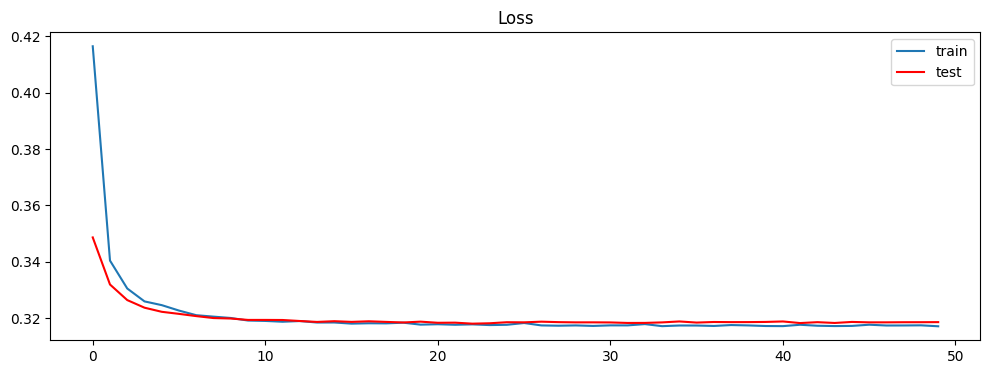

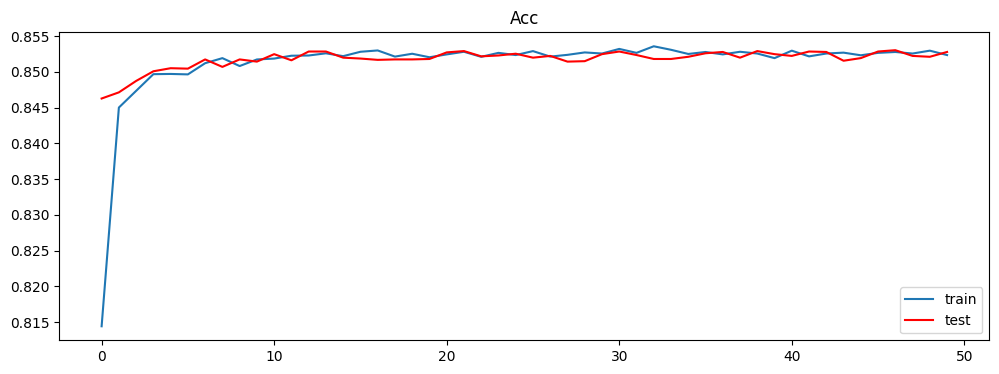

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list, c='r')
plt.legend(['train', 'test'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.legend(['train', 'test'])
plt.title('Acc')
plt.show()

In [20]:
# Comparison of our model and torch's model
print('-' * 20, 'weight' , '-' * 20)
print('Ours', model.w[:20])
print('PyTorch', torch_model.linear.weight[0][:20])
print('-' * 20, 'bias' , '-' * 20)
print('Ours', model.b)
print('PyTorch', torch_model.linear.bias)

-------------------- weight --------------------
Ours tensor([ 0.3463,  0.0743,  0.4004,  2.1397,  0.2569,  0.3668,  0.7094,  0.8611,
         0.0302,  1.6963,  0.7038,  0.8612,  0.6626, -0.0030,  0.8066,  0.4389,
         0.5078,  0.3584,  0.1531,  0.2413])
PyTorch tensor([ 0.3457,  0.0728,  0.3965,  2.3053,  0.2628,  0.3649,  0.1070, -0.0204,
        -0.0446,  0.0379,  0.0339, -0.1142, -0.0501, -0.1017, -0.0543, -0.1858,
        -0.1890, -0.0697, -0.1144, -0.1329], grad_fn=<SliceBackward0>)
-------------------- bias --------------------
Ours tensor([-2.0622])
PyTorch Parameter containing:
tensor([-2.0825], requires_grad=True)


Our own implementation and the implementation using the PyTorch APIs obtain similar weights and biases.  
But less effort is needed when using PyTorch APIs!  